
<img src="https://github.com/insaid2018/Term-1/blob/master/Images/INSAID_Full%20Logo.png?raw=true" width="240" height="360" />

# Store Item demand forecast

<img src="https://i.pinimg.com/originals/aa/a2/ac/aaa2ac7acafcacaf65cb5768272a55da.gif" align='CENTRE'><br/>

## Table of Content
1.[Objective](#section1)<br>
2.[Data loading and visualization](#section2)<br>
3.[Stationarity check](#section3)<br>
4.[Decmposition](#section4)<br>
5.[Data Transformation to achieve stationarity](#section5)<br>
6.[Plotting ACF & PACF](#section6)<br>
7.[Train Test split & Building Models](#section7)<br>
8.[Test the model](#section8)<br>
9.[Conclusion](#section9)<br>

<a id=section1></a>
1.Objective

<a id=section2></a>
2.Data loading and visualization


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pylab as plt 
%matplotlib inline   
import seaborn as sns
import keras
import warnings 
warnings.filterwarnings('ignore')

C:\Users\Wel\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Wel\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Wel\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Wel\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.p

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)


In [3]:
import pandas as pd  
dataset =  pd.read_csv('https://raw.githubusercontent.com/insaid2018/Term-3/master/Projects/Store_Item_demand_forecast.csv')
dataset.head()

date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10

In [4]:
dataset.shape

(913000, 4)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [6]:
dataset.describe()

store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000

Visualizing the dataset


Basic EDA To explore the time series data first we need to aggregate the sales by day

Overall daily sales

In [7]:
daily_sales = dataset.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = dataset.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = dataset.groupby(['item', 'date'], as_index=False)['sales'].sum()

In [8]:
daily_sales_sc = go.Scatter(x=daily_sales['date'], y=daily_sales['sales'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

Daily sales by store

In [9]:
store_daily_sales_sc = []
for store in store_daily_sales['store'].unique():
    current_store_daily_sales = store_daily_sales[(store_daily_sales['store'] == store)]
    store_daily_sales_sc.append(go.Scatter(x=current_store_daily_sales['date'], y=current_store_daily_sales['sales'], name=('Store %s' % store)))

layout = go.Layout(title='Store daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=store_daily_sales_sc, layout=layout)
iplot(fig)


Daily sales by item

In [10]:
item_daily_sales_sc = []
for item in item_daily_sales['item'].unique():
    current_item_daily_sales = item_daily_sales[(item_daily_sales['item'] == item)]
    item_daily_sales_sc.append(go.Scatter(x=current_item_daily_sales['date'], y=current_item_daily_sales['sales'], name=('Item %s' % item)))

layout = go.Layout(title='Item daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=item_daily_sales_sc, layout=layout)
iplot(fig)

In [11]:
#overview of data
print("number of different items: %i" %(len(np.unique(dataset.item))))
print("number of different stores: %i" %(len(np.unique(dataset.store))))
print("number of different dates: %i" %(len(np.unique(dataset.date))))
print("maximun date in data: %s" %(max(dataset.date)))
print("minimum date in data: %s" %(min(dataset.date)))

number of different items: 50
number of different stores: 10
number of different dates: 1826
maximun date in data: 2017-12-31
minimum date in data: 2013-01-01



Distribution of Sales

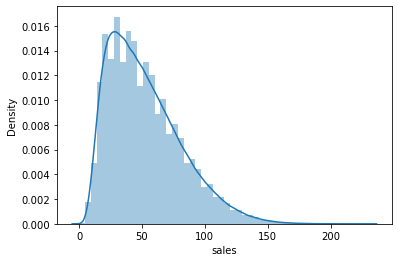

In [12]:
sns.distplot(dataset["sales"])

In [13]:
dataset['weekday']=pd.DatetimeIndex(dataset['date']).weekday
dataset['month']=pd.DatetimeIndex(dataset['date']).month 
dataset['year']=pd.DatetimeIndex(dataset['date']).year

Most Of the sales of item is around 40

Comparing Annual sales between stores

<Figure size 1080x720 with 0 Axes>

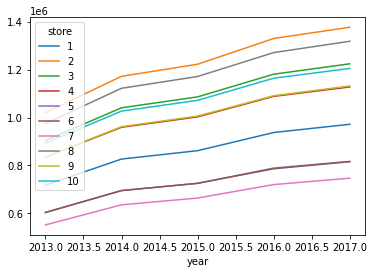

In [14]:
#we check anual sales profile comparing stores
c=dataset.groupby(['year','store']).sum()
plt.figure(figsize=(15,10))
d=c.unstack()
d.plot(y='sales')

We can see there is upward Trend in the data from the year 2013 to 2017

Comparing Monthly sales between stores

<Figure size 1080x720 with 0 Axes>

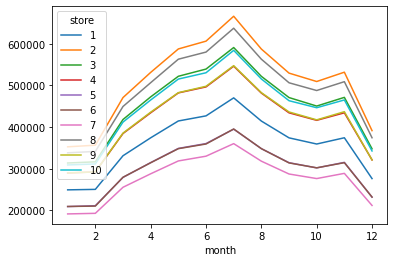

In [15]:
#we check seasonal sales profile comparing stores
c=dataset.groupby(['month', 'store']).sum()
plt.figure(figsize=(15,10))
d=c.unstack()
d.plot(y='sales')

We can observe that there is more sales in the month of July

Comparing Weekly sales between stores

<Figure size 1080x720 with 0 Axes>

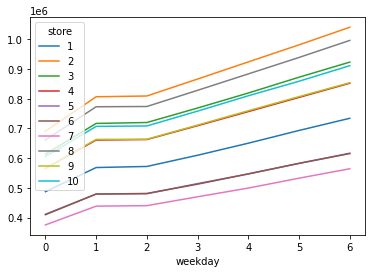

In [16]:
#we check anual sales profile comparing stores
c=dataset.groupby(['weekday','store']).sum()
plt.figure(figsize=(15,10))
d=c.unstack()
d.plot(y='sales')

In [17]:
dataset.drop(columns=["year","month","weekday"],inplace=True)
dataset.head()

date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10

We will now analyse Store 1 and Item 1

In [18]:
store1item1 = dataset.loc[(dataset['store'] == 1) & (dataset['item'] == 1)]
store1item1.head()

date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10

In [19]:
store1item1.shape

(1826, 4)

In [20]:
store1item1['date']  =  pd.to_datetime(store1item1['date'],infer_datetime_format = True)             #convert from string to datetime

indexedDataset  =  store1item1.set_index(['date'])
indexedDataset= indexedDataset.drop(columns=["store","item"])
indexedDataset.head(5)

sales
date             
2013-01-01     13
2013-01-02     11
2013-01-03     14
2013-01-04     13
2013-01-05     10

In [21]:
indexedDataset.shape

(1826, 1)

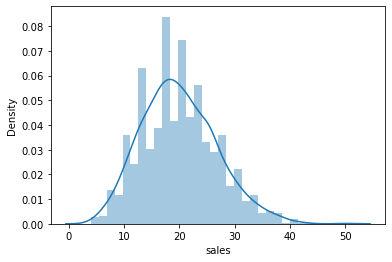

In [22]:
sns.distplot(indexedDataset["sales"])

<a id=section3></a>
3.Stationarity check
We will see two methods two check stationarity.



We will see two methods two check stationarity.
Making a function to check stationarity in one go using both rolling statistics plot and ADF test.


Rolling mean has a trend component
Rolling standard deviation is fairly constant with time.
For our time series to be stationary, we need to ensure that both the rolling statistics i.e: mean & stdandard deviation remain time invariant or constant with time. Thus the curves for both of them have to be parallel to the x-axis, which in our case is not so.

In [23]:
# Determine rolling statistics
def rolling_means(time_series):
    rolmean  =  time_series.rolling(window = 12).mean()    #window size 12 denotes 12 months, giving rolling mean at yearly level
    rolstd  =  time_series.rolling(window = 12).std()

    orig  =  plt.plot(time_series, color = 'blue', label = 'Original')
    mean  =  plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std  =  plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)

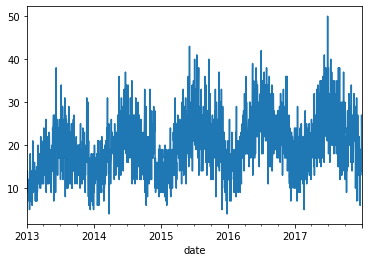

In [24]:
indexedDataset['sales'].plot()

In [25]:
#Perform Augmented Dickey–Fuller test:
def adf_test(time_series):
    
    from statsmodels.tsa.stattools import adfuller
    dftest  =  adfuller(time_series, autolag = 'AIC')

    dfoutput  =  pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        
        dfoutput['Critical Value (%s)'%key]  =  value
    
    print('Results of Dickey Fuller Test:') 
    print(dfoutput)

<a id=section4></a>
4.Decmposition

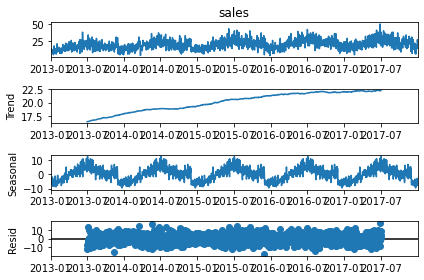

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
fig = seasonal_decompose(indexedDataset['sales'], model='additive', freq=365).plot()

From the plot above, we can see that there is a Trend compoenent and seasonal component in the series.

We will check stationarity using both rolling statistics plot and ADF test.

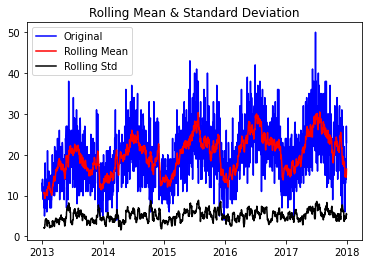

In [27]:
rolling_means(indexedDataset["sales"])

Rolling mean has a trend component
Rolling standard deviation is fairly constant with time

In [28]:
adf_test(indexedDataset['sales'])

Results of Dickey Fuller Test:
Test Statistic                   -3.157671
p-value                           0.022569
#Lags Used                       23.000000
Number of Observations Used    1802.000000
Critical Value (1%)              -3.433984
Critical Value (5%)              -2.863145
Critical Value (10%)             -2.567625
dtype: float64


The Dickey-Fuller test the time series is not considered stationary as Test Statistic greater than Critical Value at 1%  i.e. -3.157>-3.433 and we can see visually that there is an upwards trend.

<a id=section5></a>
5.Data Transformation to achieve stationarity


Try to make the data Stationary we will try

1.Log scale transform
2.Log Scale Minus Moving Average
3.Exponential Decay
4.Shift Difference


log scale transform

In [29]:
#log scale transform
import numpy as np
indexedDataset_logScale  =  np.log(indexedDataset)

In [30]:
adf_test(indexedDataset_logScale.sales)

Results of Dickey Fuller Test:
Test Statistic                   -3.594424
p-value                           0.005869
#Lags Used                       23.000000
Number of Observations Used    1802.000000
Critical Value (1%)              -3.433984
Critical Value (5%)              -2.863145
Critical Value (10%)             -2.567625
dtype: float64


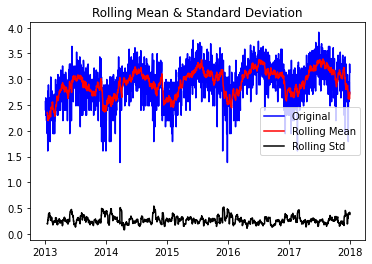

In [31]:
rolling_means(indexedDataset_logScale)

From above graph, we see that even though rolling mean is not stationary, it is still better than the previous case, where no transformation were applied to series. So we can at least say that we are heading in the right direction.


# Log Scale Minus Moving Average

In [32]:
movingAverage  =  indexedDataset_logScale.rolling(window = 12).mean()
datasetLogScaleMinusMovingAverage  =  indexedDataset_logScale - movingAverage

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace = True)

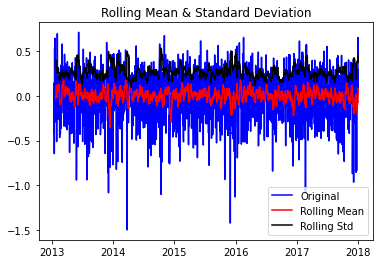

In [33]:
rolling_means(datasetLogScaleMinusMovingAverage)

From above graph, we observe that our intuition that  subtracting two related series having similar trend components will make the result stationary"* is true.


In [34]:
adf_test(datasetLogScaleMinusMovingAverage.sales)

Results of Dickey Fuller Test:
Test Statistic                -1.031707e+01
p-value                        3.077488e-18
#Lags Used                     2.000000e+01
Number of Observations Used    1.794000e+03
Critical Value (1%)           -3.434000e+00
Critical Value (5%)           -2.863152e+00
Critical Value (10%)          -2.567628e+00
dtype: float64


Data is somewhat stationary

# Exponential Decay Weighted Average

In [35]:
exponentialDecayWeightedAverage  =  indexedDataset_logScale.ewm(halflife = 12, min_periods = 0, adjust = True).mean()

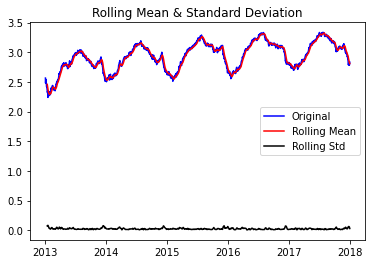

In [36]:
rolling_means(exponentialDecayWeightedAverage)

From above graph, it seems that exponential decay is not holding any advantage over log scale as both the corresponding curves are similar.


In [37]:
adf_test(exponentialDecayWeightedAverage.sales)

Results of Dickey Fuller Test:
Test Statistic                   -3.666915
p-value                           0.004603
#Lags Used                       24.000000
Number of Observations Used    1801.000000
Critical Value (1%)              -3.433986
Critical Value (5%)              -2.863146
Critical Value (10%)             -2.567625
dtype: float64


p-value has decreased and Test Statistic value is very much closer to the Critical values.
Both the points say that our current transformation is better than the previous logarithmic transformation. Even though, we couldn't observe any differences by visually looking at the graphs, the tests confirmed decay to be much better.


# Log Scale Shifting

In [38]:
datasetLogDiffShifting  =  indexedDataset_logScale - indexedDataset_logScale.shift()

In [39]:
datasetLogDiffShifting.dropna(inplace = True)

In [40]:
datasetLogDiffShifting.head()

sales
date                
2013-01-02 -0.167054
2013-01-03  0.241162
2013-01-04 -0.074108
2013-01-05 -0.262364
2013-01-06  0.182322

In [41]:
adf_test(datasetLogDiffShifting.sales)

Results of Dickey Fuller Test:
Test Statistic                -1.259629e+01
p-value                        1.775858e-23
#Lags Used                     2.200000e+01
Number of Observations Used    1.802000e+03
Critical Value (1%)           -3.433984e+00
Critical Value (5%)           -2.863145e+00
Critical Value (10%)          -2.567625e+00
dtype: float64


p-value is extemely small. Thus this series is very likely to be stationary

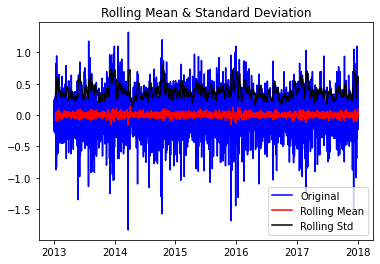

In [42]:
rolling_means(datasetLogDiffShifting)

From above graph, we can see that, visually this is the best result as our series along with rolling statistic values of moving avg & moving std. dev. is very much flat & stationary. 


 p-value is extremely small. Thus this series is very likely to be stationary.

# Data is now Stationary

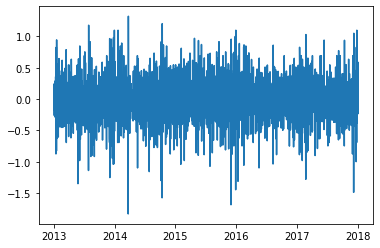

In [43]:
plt.plot(datasetLogDiffShifting)

From graphs, we can see that, visually this is the best result as our series along with rolling statistic values of moving avg & moving std. dev. is very much flat & stationary.

Test Statistic value not as close to the critical values as that for exponential decay.
We have thus tried out 4 different transformation: log, exp decay & time shift. We will go ahead with the time shifted dataset.


<a id=section6></a>
6.Plotting ACF & PACF

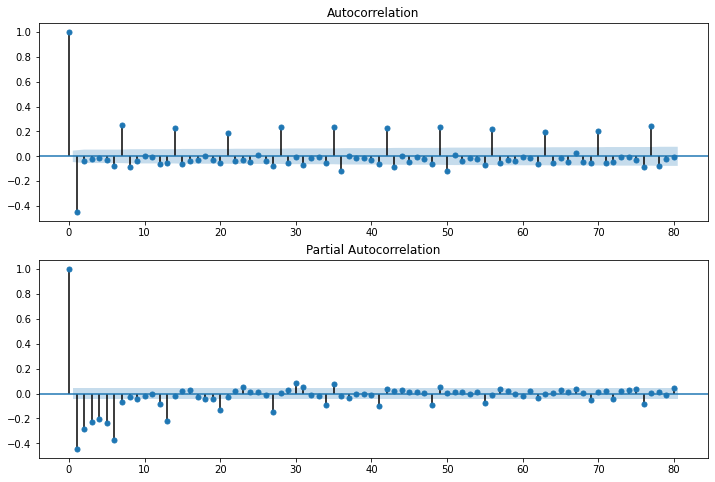

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(datasetLogDiffShifting.sales, lags=80, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = plot_pacf(datasetLogDiffShifting.sales, lags=80, ax=ax2)

P, Q value - 7

Here we can see the acf and pacf both has a recurring pattern every 7 periods. Indicating a weekly pattern exists.

Train Test split & Building Models

In [45]:
datasetLogDiffShifting.shape

(1825, 1)

In [46]:
# Data Preparation
#testing last 100 days
train, test = datasetLogDiffShifting[0:len(datasetLogDiffShifting)-100], datasetLogDiffShifting[len(datasetLogDiffShifting)-100:]
train.head()

sales
date                
2013-01-02 -0.167054
2013-01-03  0.241162
2013-01-04 -0.074108
2013-01-05 -0.262364
2013-01-06  0.182322

In [47]:
test.head()

sales
date                
2017-09-23  0.278713
2017-09-24 -0.432864
2017-09-25 -0.538997
2017-09-26  0.251314
2017-09-27  0.405465

In [48]:
test.tail()

sales
date                
2017-12-27 -0.133531
2017-12-28  0.305382
2017-12-29 -0.236389
2017-12-30  0.587787
2017-12-31 -0.160343

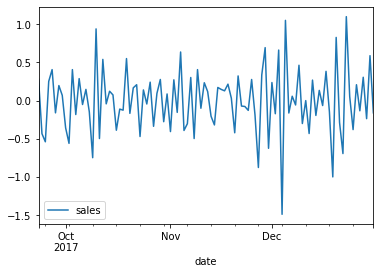

In [49]:
test.plot()

In [50]:
print(train.shape)
print(test.shape)

(1725, 1)
(100, 1)


Summary of ARMA Model:
Forecasting using the developed model and printing out the 7 month forecast.



In [51]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA (train, order=(7,0,7))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\Wel\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Wel\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\Wel\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                              ARMA Model Results                              
Dep. Variable:                  sales   No. Observations:                 1725
Model:                     ARMA(7, 7)   Log Likelihood                 -99.607
Method:                       css-mle   S.D. of innovations              0.255
Date:                Wed, 09 Dec 2020   AIC                            231.213
Time:                        19:14:22   BIC                            318.461
Sample:                    01-02-2013   HQIC                           263.489
                         - 09-22-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0004      0.001      0.687      0.492      -0.001       0.002
ar.L1.sales    -0.9856      0.000  -3052.021      0.000      -0.986      -0.985
ar.L2.sales    -0.9850      0.001  -1754.320    

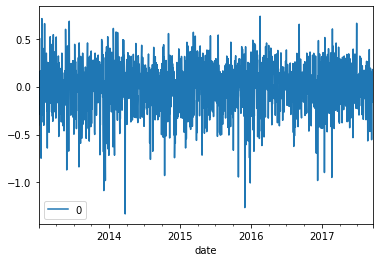

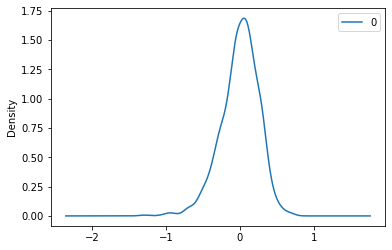

                 0
count  1725.000000
mean     -0.000483
std       0.256522
min      -1.328668
25%      -0.144559
50%       0.022271
75%       0.167040
max       0.735172


In [52]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [53]:
model_fit.fittedvalues.head()

date
2013-01-02    0.000448
2013-01-03    0.076891
2013-01-04   -0.091828
2013-01-05   -0.017807
2013-01-06    0.173153
dtype: float64

In [54]:
print(train.shape)
print(model_fit.fittedvalues.shape)

(1725, 1)
(1725,)


In [55]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
error = mean_squared_error(train, model_fit.fittedvalues)
print('Train MSE: %.3f' % error)

Train MSE: 0.066


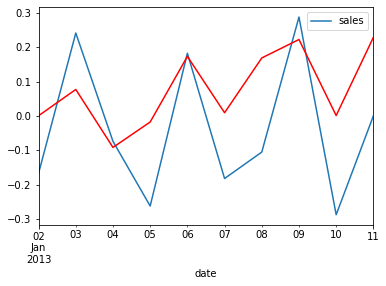

In [56]:
train.head(10).plot()
model_fit.fittedvalues.head(10).plot(color='red')

Test MSE: 0.066
Observing the plot of expected vs the predicted.
The forecast does look pretty good with slightly large deviation.


<a id=section8></a>
8.Test the model

In [57]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(datasetLogDiffShifting)-1, dynamic=False)

In [58]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results

Test MSE: 0.134


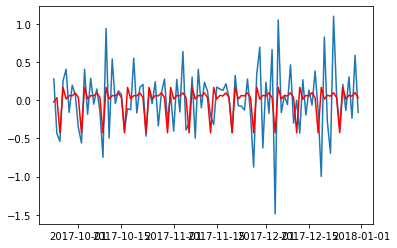

In [59]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

Test MSE: 0.134
We see that our predicted forecasts are very close to the real time series values indicating a fairly accurate model.


<a id=section9></a>
9.Conclusion


We have built a model to forecast the demand of item 1 sales in a Store 1
Using ARIMA model with P value and Q value 7 Since we observed the acf and pacf both has a recurring pattern every 7 periods. Indicating a weekly pattern exists.

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRJTdh4YKHW-bu2GUZs_L-01DJ7u5YopogZvg&usqp=CAU" align='CENTRE'><br/>